In [1]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('kuzushiji_resized/traincsv.csv')
df

,image_id,labels
0,100241706_00004_2,U+306F 586.824459234609 1728.922302529685 66.3...
1,100241706_00005_1,U+306F 520.7784280936455 1006.916365513681 51....
2,100241706_00005_2,U+306F 271.3211920529801 686.5792462570986 62....
3,100241706_00006_1,U+3082 705.9398814563929 1496.7568193515183 32...
4,100241706_00007_2,U+309D 575.3954849498328 1473.7375904860394 13...
...,...,...
3600,umgy012-038,U+30FD 582.3062645011602 526.0948453608247 15....
3601,umgy012-039,U+309D 271.0694058856191 301.65913757700207 19...
3602,umgy012-040,U+30DE 441.0699260943718 216.91523678792038 45...
3603,umgy012-041,U+309D 982.640650406504 526.942895989123 10.51...


In [3]:
fontsize = 50

font = ImageFont.truetype('./kuzushiji/NotoSansCJKjp-Regular.otf', fontsize, encoding='utf-8')

In [4]:
df_train = pd.read_csv('kuzushiji/traincsv/train.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('kuzushiji/unicode_translation.csv').values}

In [5]:
def Extract_Data():
    X_=[]
    y_=[]
    for image_id, labels in tqdm(df[:1000].values):
        try:
            image_fn = 'kuzushiji_resized/train_images/{}.jpg'.format(image_id)
            ls = labels.split(' ')
            index = len(ls) - 1
            ls1 = ls[:index]
            labels1 = np.array(ls1).reshape(-1, 5)

            imsource = Image.open(image_fn).convert('RGBA')
            bbox_canvas = Image.new('RGBA', imsource.size)
            char_canvas = Image.new('RGBA', imsource.size)
            bbox_draw = ImageDraw.Draw(bbox_canvas)
            char_draw = ImageDraw.Draw(char_canvas)

            for codepoint, x, y, w, h in labels1:
                x, y, w, h = float(x), float(y), float(w), float(h)
                char = unicode_map[codepoint]

                Croped_image = imsource.crop((x, y, x+w, y+h))
                image = Croped_image.resize((100,100))
                image = np.asarray(image)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                X_.append(image)
                y_.append(str(unicode_map[codepoint]))
        except:
            print("exception")
            pass
    print(X_)
    X_ = np.array(X_)
    y_ = np.array(y_)

    return X_,y_

In [6]:
XX_,yy_ = Extract_Data()

 57%|█████████████████████████████████████████████                                  | 571/1000 [00:25<00:25, 17.05it/s]

exception


 60%|███████████████████████████████████████████████▍                               | 601/1000 [00:27<00:26, 15.02it/s]

exception


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [00:34<00:19, 15.07it/s]

exception


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.51it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:

title = yy_[51839]

              焼


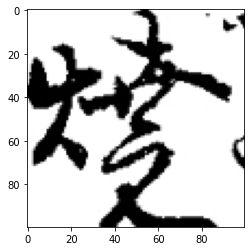

In [33]:
# -*- coding: utf-8 -*-
plt.figure()
plt.imshow(XX_[51839], 'gray')
print("             ",title)

In [31]:
XX_.shape

(174861, 100, 100)

In [10]:
yy_.shape

(174861,)

In [11]:
XX2_ = XX_[:100000]
yy2_ = yy_[:100000]

In [12]:
unique, counts = np.unique(yy2_, return_counts=True)
print(unique, counts )

['?' '▲' '○' ... '鼾' '齢' '蓮'] [  1  54 198 ...   2   1   1]


In [34]:
i = 0
classes = []
for c in counts:
    if(c >= 300):
        cl = unique[i]
        classes.append(cl)
#         print(cl)
    i+=1

In [14]:
len(classes)

59

In [15]:
j = 0
yy1_ = []
XX1_ = []
for y in yy2_:
    if(y in classes):
        yy1_.append(y)
        XX1_.append(XX2_[j])
    j+= 1

In [16]:
X_ = np.array(XX1_)
y_ = np.array(yy1_)

In [17]:
print(X_.shape)
print(y_.shape)

(64459, 100, 100)
(64459,)


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn import metrics

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv3D, BatchNormalization, MaxPool2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint
from datetime import datetime

from keras import backend as K


In [18]:
leinst = LabelEncoder()
yyinst = leinst.fit_transform(y_)

x_train, x_test, y_train, y_test = train_test_split(X_, yyinst, test_size=0.3, shuffle=True, random_state=42)

x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.3, shuffle=True, random_state=42)

# x_train = x_train.reshape(len(x_train),128,44,1)
# x_test = x_test.reshape(len(x_test),128,44,1)
# x_validation = x_validation.reshape(len(x_validation),128,44,1)
print(x_train.shape)
print(x_test.shape)
print(x_validation.shape)


num_classes = len(leinst.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
y_validation = to_categorical(y_validation, num_classes=num_classes)

(45121, 100, 100)
(13536, 100, 100)
(5802, 100, 100)


In [19]:
num_classes

59

In [26]:
K.clear_session()
def Kuzushiji_Classifier(in_):
    model_ = Conv2D(64,kernel_size=(3, 3),activation='relu')(in_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(32,kernel_size=(3, 3),activation='relu')(model_)
    model_ = MaxPooling2D(pool_size=(2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(0.4)(model_)
    
    model_ = Conv2D(32,kernel_size=(3, 3), strides=2,activation='relu')(model_)
    model_ = MaxPooling2D(pool_size=(2, 2))(model_)
    model_ = BatchNormalization()(model_)
    model_ = Dropout(0.4)(model_)
    
    model_ = Flatten()(model_)
    model_ = Dense(128, activation='relu')(model_)
    model_ = Dropout(0.4)(model_)
    model_ = Dense(num_classes, activation='softmax')(model_)
    return model_

In [27]:
Input_Sample = Input(shape=(100, 100, 1))
Output_ = Kuzushiji_Classifier(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

In [28]:
Model_Enhancer.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
Model_Enhancer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128   

In [29]:
checkpointer = ModelCheckpoint('model_Kuzushiji111.h5', verbose=0,mode='auto', monitor='val_accuracy',save_best_only=True)

In [30]:
ModelHistory = Model_Enhancer.fit(x_train, y_train,
          batch_size=30,
          epochs=20,
          verbose=1,callbacks=[checkpointer],
          validation_data=(x_validation, y_validation))

Epoch 1/20
1505/1505 [==============================] - 877s 582ms/step - loss: 1.6184 - accuracy: 0.6010 - val_loss: 0.6505 - val_accuracy: 0.8228
Epoch 2/20
1505/1505 [==============================] - 874s 581ms/step - loss: 0.8348 - accuracy: 0.7715 - val_loss: 0.4682 - val_accuracy: 0.8799
Epoch 3/20
1505/1505 [==============================] - 910s 605ms/step - loss: 0.6749 - accuracy: 0.8122 - val_loss: 0.4704 - val_accuracy: 0.8716
Epoch 4/20
1505/1505 [==============================] - 906s 602ms/step - loss: 0.5867 - accuracy: 0.8343 - val_loss: 0.3671 - val_accuracy: 0.9045
Epoch 5/20
1505/1505 [==============================] - 909s 604ms/step - loss: 0.5397 - accuracy: 0.8457 - val_loss: 0.3653 - val_accuracy: 0.9045
Epoch 6/20
1505/1505 [==============================] - 851s 566ms/step - loss: 0.4860 - accuracy: 0.8577 - val_loss: 0.3403 - val_accuracy: 0.9105
Epoch 7/20
1505/1505 [==============================] - 828s 550ms/step - loss: 0.4504 - accuracy: 0.8672 - val_

In [31]:
train_score = Model_Enhancer.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

1411/1411 [==============================] - 124s 88ms/step - loss: 0.0468 - accuracy: 0.9901
Training Accuracy:  0.9901154637336731


In [32]:
test_score = Model_Enhancer.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

423/423 [==============================] - 39s 91ms/step - loss: 0.2297 - accuracy: 0.9417
Test Accuracy:  0.9417110085487366
